### Model bazowy – predykcja niewypłacalności klienta

Celem tego etapu jest zbudowanie prostego, interpretowalnego modelu bazowego, który posłuży jako punkt odniesienia dla dalszych ulepszeń.

In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from xgboost import XGBClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    classification_report, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt


In [2]:
train_df = pd.read_parquet("train.parquet")
test_df  = pd.read_parquet("test.parquet")

print("train:", train_df.shape, "test:", test_df.shape)
print(train_df.columns)


train: (20000, 11) test: (5000, 11)
Index(['Age', 'Income', 'CreditScore', 'LoanAmount', 'EmploymentYears',
       'NumDependents', 'DebtToIncome', 'EducationLevel', 'FavoriteColor',
       'Hobby', 'Default'],
      dtype='object')


In [3]:
target = "Default"

num_features = [
    "Age", "Income", "CreditScore", "LoanAmount",
    "EmploymentYears", "NumDependents", "DebtToIncome", "EducationLevel",
    "Income_per_Dependent", "Loan_to_Income", "Employment_Ratio"
]

cat_features = ["FavoriteColor", "Hobby"]


In [4]:
target = "Default"

num_features = [
    "Age", "Income", "CreditScore", "LoanAmount",
    "EmploymentYears", "NumDependents", "DebtToIncome", "EducationLevel",
    "Income_per_Dependent", "Loan_to_Income", "Employment_Ratio"
]

cat_features = ["FavoriteColor", "Hobby"]


## Feature engineering (baseline)

Na etapie modelu bazowego wprowadziłem trzy proste, ale interpretowalne cechy pochodne, które lepiej oddają realną sytuację finansową i stabilność klienta niż surowe kolumny wejściowe:

- **Income_per_Dependent** = `Income / (NumDependents + 1)`  
  Dochód „na osobę” – uwzględnia liczbę osób na utrzymaniu (zabezpieczenie przed dzieleniem przez zero).

- **Loan_to_Income** = `LoanAmount / Income`  
  Relacja kwoty pożyczki do dochodu – klasyczny wskaźnik ryzyka kredytowego.

- **Employment_Ratio** = `EmploymentYears / Age`  
  Stabilność zatrudnienia w relacji do wieku klienta.

Cechy te są obliczane w identyczny sposób dla zbioru treningowego i testowego, aby zachować spójność danych i uniknąć *data leakage*.  
Dodatkowo zastosowano proste zabezpieczenia przed dzieleniem przez zero i wartościami skrajnymi.


In [6]:
def prepare_data(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()

    df["Income_per_Dependent"] = df["Income"] / (df["NumDependents"].fillna(0) + 1)

    income = df["Income"].replace(0, np.nan)
    df["Loan_to_Income"] = df["LoanAmount"] / income

    age = df["Age"].replace(0, np.nan)
    df["Employment_Ratio"] = df["EmploymentYears"] / age

    df = df.replace([np.inf, -np.inf], np.nan)
    return df


In [7]:
train_df = prepare_data(train_df)
test_df  = prepare_data(test_df)

# szybki check
print([c for c in ["Income_per_Dependent","Loan_to_Income","Employment_Ratio"] if c in train_df.columns])

X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_test = test_df.drop(columns=[target])
y_test = test_df[target]


['Income_per_Dependent', 'Loan_to_Income', 'Employment_Ratio']


ROC-AUC (test): 0.8012061588103254
PR-AUC (test): 0.6810136822796821
              precision    recall  f1-score   support

           0      0.773     0.844     0.807      3240
           1      0.654     0.544     0.594      1760

    accuracy                          0.738      5000
   macro avg      0.714     0.694     0.700      5000
weighted avg      0.731     0.738     0.732      5000



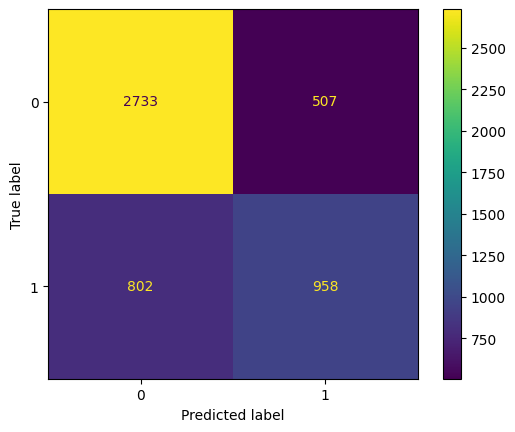

In [8]:
num_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer([
    ("num", num_transformer, num_features),
    ("cat", cat_transformer, cat_features)
])

pipeline_xgb = Pipeline([
    ("prep", preprocessor),
    ("model", XGBClassifier(
        n_estimators=200,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric="logloss",
        random_state=42
    ))
])

pipeline_xgb.fit(X_train, y_train)

y_proba = pipeline_xgb.predict_proba(X_test)[:, 1]
y_pred = (y_proba >= 0.5).astype(int)

print("ROC-AUC (test):", roc_auc_score(y_test, y_proba))
print("PR-AUC (test):", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred, digits=3))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.show()


## Wyniki modelu bazowego

Model bazowy (XGBoost + pipeline z imputacją i kodowaniem) osiągnął:

- ROC-AUC: ~0.80  
- PR-AUC: ~0.68  
- Recall klasy „Default”: ~0.54  

Stanowi to punkt odniesienia dla dalszych iteracji.  
Kolejne kroki będą skupione na poprawie wykrywalności klientów wysokiego ryzyka
poprzez zmianę progu decyzyjnego, wagi klas oraz tuning hiperparametrów.
